# Classification of the Abalone dataset
Dataset can be downloaded from https://archive.ics.uci.edu/ml/datasets/Abalone
The goal is to predict the age of abalone (function of the number of rings) from its physical measurements

## Loading modules and dataset

In [106]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 6] #Set the default figure size for this notebook

In [2]:
file_ds_data = 'abalone.data'

cols = ['Sex','Length', 'Diameter', 'Height', 'WholeWeight',
        'ShuckedWeight', 'VisceraWeight', 'ShellWeight', 'Rings']
df = pd.read_csv(file_ds_data, names=cols)

## Data checking
Before even thinking about running our model, we have to verify a few things in the dataset

#### Columns types

In [3]:
df.info() #Make sure types have been correctly parsed and that all columns have non-zero values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4177 entries, 0 to 4176
Data columns (total 9 columns):
Sex              4177 non-null object
Length           4177 non-null float64
Diameter         4177 non-null float64
Height           4177 non-null float64
WholeWeight      4177 non-null float64
ShuckedWeight    4177 non-null float64
VisceraWeight    4177 non-null float64
ShellWeight      4177 non-null float64
Rings            4177 non-null int64
dtypes: float64(7), int64(1), object(1)
memory usage: 293.8+ KB


Our DataFrame has 4177 non-null instances. The _Sex_ attribute has a type object (as it contains strings), and will need to be encoded later.

In [4]:
df['Sex'].value_counts() 

M    1528
I    1342
F    1307
Name: Sex, dtype: int64

The _Sex_ attribute has three values: _Male_ (M), _Female_ (F), and _Infant_ (I)

#### Data outliers

In [5]:
df.describe()

,Length,Diameter,Height,WholeWeight,ShuckedWeight,VisceraWeight,ShellWeight,Rings
count,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000
mean,0.523992,0.407881,0.139516,0.828742,0.359367,0.180594,0.238831,9.933684
std,0.120093,0.099240,0.041827,0.490389,0.221963,0.109614,0.139203,3.224169
min,0.075000,0.055000,0.000000,0.002000,0.001000,0.000500,0.001500,1.000000
25%,0.450000,0.350000,0.115000,0.441500,0.186000,0.093500,0.130000,8.000000
50%,0.545000,0.425000,0.140000,0.799500,0.336000,0.171000,0.234000,9.000000
75%,0.615000,0.480000,0.165000,1.153000,0.502000,0.253000,0.329000,11.000000
max,0.815000,0.650000,1.130000,2.825500,1.488000,0.760000,1.005000,29.000000


We can see that the Height attribute has a mimimum value of 0, which is very likely a missing measurement. There are multiple ways to identify outliers. IQR and Z-Score are probably the most common.
As part of this project, I will use the Z-score metrics, and use a threshold of 3, i.e remove any point that is more than 3 standard deviations away from the mean.

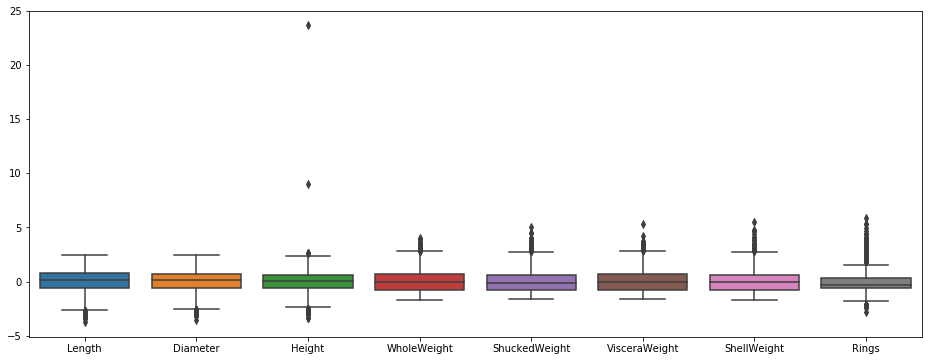

In [107]:
import seaborn as sn
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np

z_df = df.iloc[:,1:].apply(stats.zscore)
sn.boxplot(data=z_df);

In [7]:
df_no_outl = df[(z_df.abs() < 3).all(axis=1)] # Filter data 3sd from the mean
df_no_outl.reset_index(inplace=True, drop=True) # Required because we removed some entries
print("""Size:
      Original dataset: {} / Without outliers: {}""".format(df.shape,df_no_outl.shape))

Size:
      Original dataset: (4177, 9) / Without outliers: (4027, 9)


In [8]:
df_no_outl.describe()

,Length,Diameter,Height,WholeWeight,ShuckedWeight,VisceraWeight,ShellWeight,Rings
count,4027.000000,4027.000000,4027.000000,4027.000000,4027.000000,4027.000000,4027.000000,4027.000000
mean,0.520987,0.405300,0.138002,0.802805,0.349099,0.175718,0.230676,9.738763
std,0.115910,0.095903,0.036878,0.456192,0.206406,0.103350,0.127939,2.864691
min,0.165000,0.115000,0.015000,0.014500,0.005500,0.000500,0.005000,3.000000
25%,0.450000,0.345000,0.115000,0.438000,0.182000,0.091750,0.127750,8.000000
50%,0.540000,0.420000,0.140000,0.783000,0.329500,0.167000,0.225000,9.000000
75%,0.610000,0.480000,0.165000,1.131250,0.493500,0.246500,0.320000,11.000000
max,0.760000,0.605000,0.250000,2.238500,1.017000,0.492500,0.655000,19.000000


### Missing values
Note that we already see in the output above of df.info() that all columns are not null

In [9]:
df_no_outl.isnull().sum() #Any missing values?

Sex              0
Length           0
Diameter         0
Height           0
WholeWeight      0
ShuckedWeight    0
VisceraWeight    0
ShellWeight      0
Rings            0
dtype: int64

### Attribute correlation

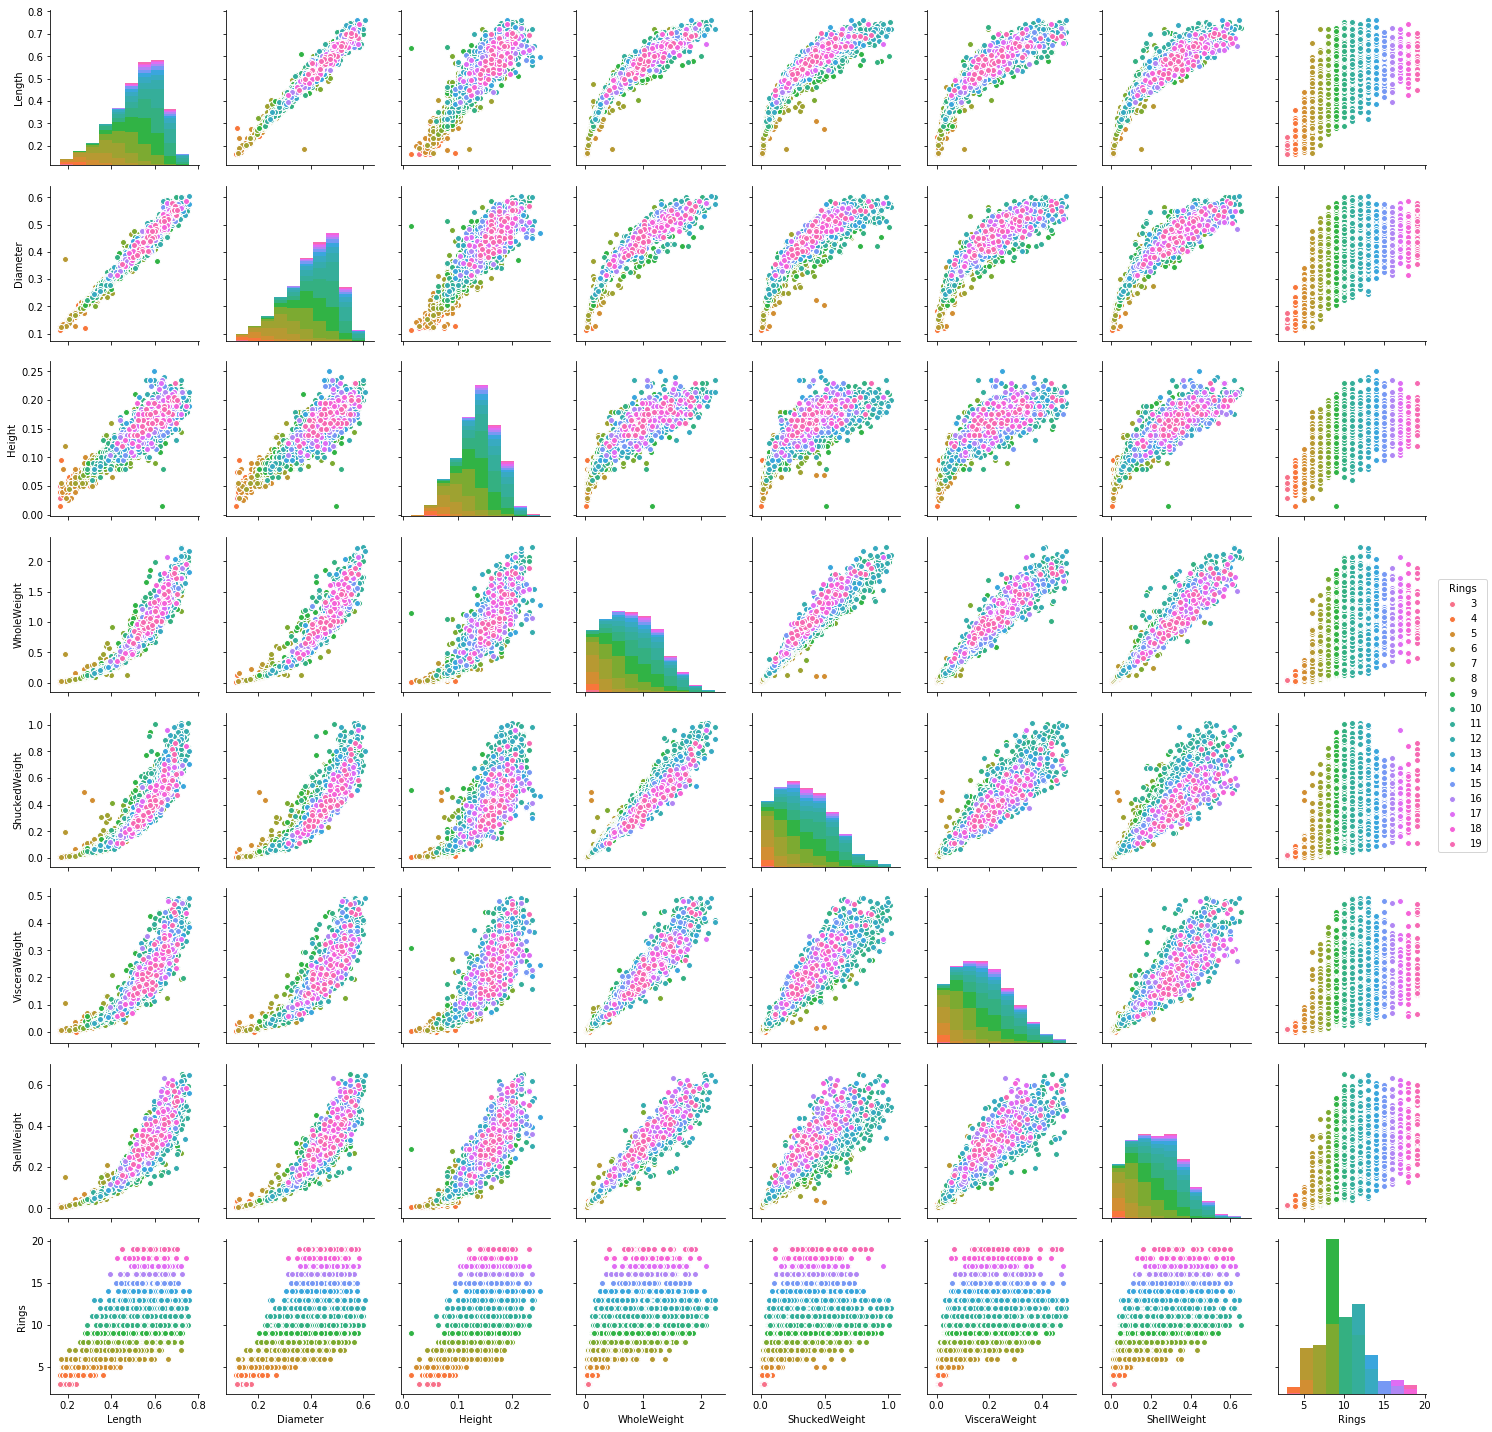

In [10]:
sn.pairplot(df_no_outl, hue='Rings');

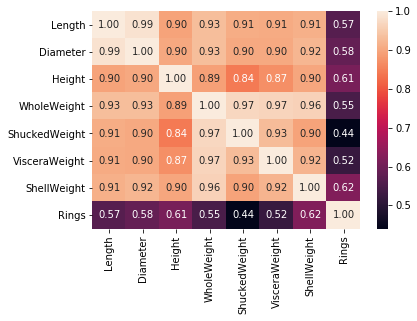

In [11]:
corr = df_no_outl.corr()
sn.heatmap(corr, annot=True, fmt=".2f")

Many features are highly correlated (> 0.9): length with diameter, whole weight with visceral weight to name only a few. It means that we ould easily reduce the number of features using LASSO without too much impact on the performance

### Feature engineering
From the dataset information, the age is simply equal to _rings_ + 1.5. We can then directly transform the _rings_ attribute into a more meaningful _age_ attribute

In [12]:
df_no_outl.loc[:,'Age'] = df_no_outl.loc[:,'Rings'] + 1.5
df_abalone = df_no_outl.drop(columns=['Rings'])

C:\WinPython\python-3.6.5.amd64\lib\site-packages\pandas\core\indexing.py:357: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\WinPython\python-3.6.5.amd64\lib\site-packages\pandas\core\indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


## Data preparation
We can now execute steps specific to the regression model

### One-hot encoding of the categorical variable

In [20]:
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(sparse=False, drop='first') #Required to remove colinearity between ohe categories
sex_ohe = ohe.fit_transform(df_abalone['Sex'].values.reshape(-1,1))
sex_ohe_df = pd.DataFrame(sex_ohe, columns=ohe.get_feature_names())
df_ohe = pd.concat([sex_ohe_df, df_abalone.drop('Sex', axis=1)], axis=1)
df_ohe.head()

,x0_I,x0_M,Length,Diameter,Height,WholeWeight,ShuckedWeight,VisceraWeight,ShellWeight,Age
0,0.0,1.0,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,16.5
1,0.0,1.0,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,8.5
2,0.0,0.0,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,10.5
3,0.0,1.0,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,11.5
4,1.0,0.0,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,8.5


### Split into training and testing dataset

In [21]:
from sklearn.model_selection import train_test_split

X = df_ohe.drop('Age', axis=1)
y = df_ohe['Age']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

### Normalizing training dataset

In [22]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(X_train)
X_scaled = scaler.transform(X_train)

Scaling the target is not required as per (https://stats.stackexchange.com/questions/111467/is-it-necessary-to-scale-the-target-value-in-addition-to-scaling-features-for-re). The idea of scaling is to improve convergence speed, and it is not affected by the scale of the target variables

### Shuffling
By default, train_test_split shuffles the dataset. Not required here

In [16]:
# from sklearn.utils import shuffle
# X_train_shuff, y_train_shuff = shuffle(X_scaled, y_train, random_state=0)

# Training!
Since we want to predict a continuous variable, we need to run regression model. To reduce over-fitting, we'll run 5-fold cross-validation 

In [150]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate
reg_lin = LinearRegression(fit_intercept=False)
cv_results = cross_validate(reg_lin, X_train, y_train, cv=5, scoring='neg_mean_squared_error', return_estimator=True)
cv_results.keys()
print('CV scores: ', cv_results['test_score'])

CV scores:  [-4.36777566 -3.79220755 -4.39145582 -4.464025   -3.70831869]


cross_validate return each estimator, and thus it is easy to find the coefficients of the best model

In [153]:
best_est_idx = np.argmax(cv_results['test_score'])
best_est = cv_results['estimator'][best_est_idx]
print('BEST ESTIMATOR - LINEAR REGRESSION')
print('--------------------')
print('RMSE: {:.2f} years'.format(np.sqrt(np.abs(cv_results['test_score'][best_est_idx]))))
print('--------------------')
print('Coefficients: ')
for attr, c in zip(X_train.columns,best_est.coef_):
    print(attr,': {:.2f}'.format(c))

BEST ESTIMATOR - LINEAR REGRESSION
--------------------
RMSE: 1.93 years
--------------------
Coefficients: 
x0_I : -0.17
x0_M : 0.27
Length : 7.47
Diameter : 14.07
Height : 27.73
WholeWeight : 7.76
ShuckedWeight : -20.74
VisceraWeight : -11.34
ShellWeight : 3.22


Text(0,0.5,'Predicted age')

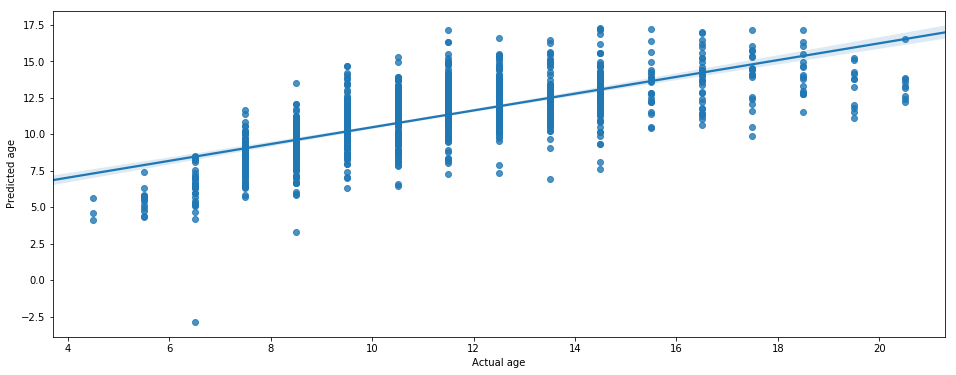

In [152]:
y_pred = best_est.predict(X_test)
sn.regplot(x=y_test, y=y_pred);
plt.xlabel('Actual age')
plt.ylabel('Predicted age')

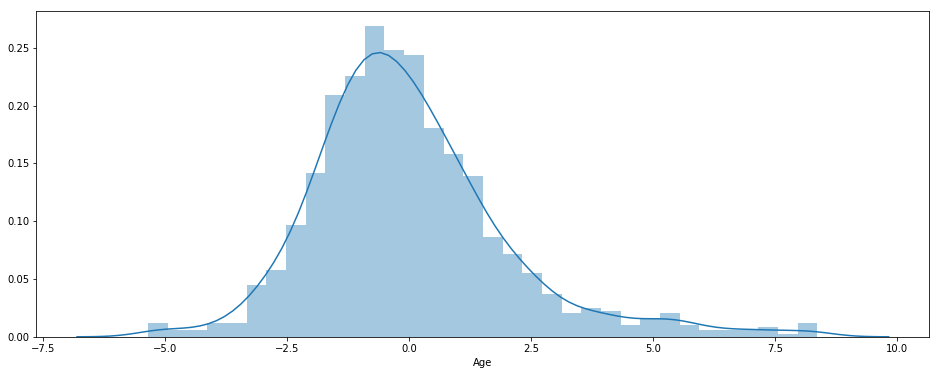

In [126]:
residuals = y_test - y_pred
sn.distplot(residuals)

## Final score
The score of the best model is then evaluated on the test set

In [142]:
from sklearn.metrics import mean_absolute_error
y_test_predict = best_est.predict(X_test)

mae = mean_absolute_error(y_test, y_test_predict)
print('RMSE: {:.2f} years'.format(np.sqrt(np.abs(mae))))

RMSE: 1.22 years


# Conclusions
This study was the simplest model that we can train on the Abalone dataset. Because a lot of attributes are highly correlated, it is possible to use regularization to identify the most significant attributes.

The linear regression model has a root mean square error of 1.22 years and its coefficients are

| Attribute | Coefficent   |
|------|------|
|   Infant  | -0.69|
|   Male  | 0.02|
|   Length  | -2.50|
|   Diameter  | 13.24|
|   Height  | 18.77|
|   WholeHeight  | 7.84|
|   ShuckedWeight  | -18.50|
|   VisceraWeight  | -9.25|
|   ShellWeight  | 7.68|